In [311]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score
from preprocessing_functions import *

# Importing the model and the data


In [312]:
heart_attack_2020 = pd.read_csv(r'C:\Users\Hp\Documents\Machine_learning_projects\heart_attack_predictions\0_datasets\2020\heart_2020_cleaned.csv')
heart_attack_2020 = undersample_data(heart_attack_2020, 'HeartDisease')

print(heart_attack_2020.value_counts('HeartDisease'))

HeartDisease
No     27373
Yes    27373
Name: count, dtype: int64


In [313]:
heart_attack_2020

,HeartDisease,BMI,Smoking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
111390,No,25.02,No,No,No,Female,50-54,White,No,Yes,Good,6.0,Yes,No,Yes
250162,No,23.30,No,No,No,Female,50-54,Black,No,Yes,Good,7.0,No,No,No
230713,No,25.77,Yes,No,No,Male,45-49,White,No,Yes,Very good,4.0,Yes,No,No
153210,No,25.61,Yes,Yes,No,Female,25-29,White,Yes,No,Fair,6.0,No,No,No
149117,No,31.16,Yes,No,Yes,Female,65-69,Black,No,Yes,Fair,7.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319765,Yes,38.45,No,Yes,Yes,Female,55-59,Hispanic,Yes,Yes,Poor,6.0,Yes,No,No
319767,Yes,36.21,Yes,No,Yes,Female,75-79,Hispanic,Yes,Yes,Good,8.0,No,No,No
319781,Yes,37.12,Yes,No,No,Male,35-39,Hispanic,No,Yes,Very good,7.0,No,No,No
319786,Yes,33.20,Yes,No,No,Female,60-64,Hispanic,Yes,Yes,Very good,8.0,Yes,No,No


In [314]:
# numerical features
numerical_features = ['BMI','SleepTime']
# categorical features
categorical_features = ['Smoking', 'Stroke', 'DiffWalking', 'Sex','AgeCategory', 'Race', 'Diabetic', 
                        'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']

heart_attack_2020 = heart_attack_2020[numerical_features + categorical_features + ['HeartDisease']]

# Encoding, scaling and train test split
(Train_df,Train_df_encoded, Train_labels_encoded), (Valid_df, Valid_df_encoded, Valid_labels_encoded), (Test_df, Test_df_encoded, 
    Test_labels_encoded) = preprocess_features_retrieve_df(heart_attack_2020.copy(), one_hot_encoding=False,
            categorical_columns=categorical_features, numerical_tranformer = 'log_min_max',
                numerical_columns=numerical_features, target='HeartDisease')
Test_df.head()

,BMI,SleepTime,Smoking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
69116,21.14,7.0,Yes,No,No,Female,45-49,Hispanic,No,Yes,Very good,No,No,No
250503,28.89,6.0,No,No,No,Male,50-54,White,No,No,Good,No,No,No
290960,22.27,9.0,Yes,No,No,Female,80 or older,White,No,Yes,Poor,Yes,No,No
19389,14.17,5.0,Yes,Yes,Yes,Female,55-59,White,No,No,Good,No,No,No
254873,22.86,7.0,No,No,No,Female,60-64,White,Yes,Yes,Poor,No,No,No


# Evaluating the best model (Dense)

In [315]:
# load model 
model_dense = tf.keras.models.load_model(r'C:\Users\Hp\Documents\Machine_learning_projects\heart_attack_predictions\4_saved_models\conv1D_model_best.h5') 
model_dense.evaluate(Test_df_encoded, Test_labels_encoded)
class_names = ['No Disease', 'Heart Disease']
test_pred_probs = model_dense.predict(Test_df_encoded)
test_predictions = tf.squeeze(tf.round(test_pred_probs))
test_predictions = np.array(test_predictions, dtype=int)
test_predictions

120/120 [==============================] - 0s 3ms/step


array([0, 0, 1, ..., 1, 0, 1])

In [316]:
results_dict = {
                'correct_label': [class_names[i] for i in Test_labels_encoded], 
                'Prediction': [class_names[i] for i in test_predictions], 
                'Correct': [class_names[i] == class_names[j] for i, j in zip(Test_labels_encoded, test_predictions)],
                'pred_prob': [max(i) for i in test_pred_probs],
                }
results_df = pd.DataFrame(results_dict)
results_df = pd.concat([results_df, Test_df.reset_index()], axis=1).drop('index', axis=1)

# replaceing some values with ordered ones
mapping = {'Poor': '0_Poor', 'Fair': '1_Fair', 'Good': '2_Good', 'Very good': '3_Very good', 'Excellent': '4_Excellent'}
results_df['GenHealth'] = results_df['GenHealth'].replace(mapping)

results_df.head()

,correct_label,Prediction,Correct,pred_prob,BMI,SleepTime,Smoking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
0,No Disease,No Disease,True,0.156218,21.14,7.0,Yes,No,No,Female,45-49,Hispanic,No,Yes,3_Very good,No,No,No
1,Heart Disease,No Disease,False,0.274812,28.89,6.0,No,No,No,Male,50-54,White,No,No,2_Good,No,No,No
2,No Disease,Heart Disease,False,0.808630,22.27,9.0,Yes,No,No,Female,80 or older,White,No,Yes,0_Poor,Yes,No,No
3,Heart Disease,Heart Disease,True,0.738589,14.17,5.0,Yes,Yes,Yes,Female,55-59,White,No,No,2_Good,No,No,No
4,Heart Disease,Heart Disease,True,0.664638,22.86,7.0,No,No,No,Female,60-64,White,Yes,Yes,0_Poor,No,No,No


## Classification report

In [317]:
print(classification_report(tf.round(test_predictions), Test_labels_encoded))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      1704
           1       0.80      0.74      0.77      2129

    accuracy                           0.76      3833
   macro avg       0.75      0.76      0.75      3833
weighted avg       0.76      0.76      0.76      3833



## Most wrong predictions

In [318]:
wrong_results_df = results_df[results_df['Correct'] == False].sort_values(['pred_prob'], ascending=False)
print(wrong_results_df.shape)   
wrong_results_df.head(10)

(938, 18)


,correct_label,Prediction,Correct,pred_prob,BMI,SleepTime,Smoking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
2770,No Disease,Heart Disease,False,0.973425,36.84,6.0,No,Yes,No,Female,60-64,Asian,Yes,Yes,2_Good,No,No,No
1259,No Disease,Heart Disease,False,0.965440,23.73,8.0,No,No,Yes,Male,80 or older,White,No,Yes,0_Poor,No,Yes,No
2431,No Disease,Heart Disease,False,0.963636,25.84,6.0,Yes,Yes,No,Male,60-64,Asian,No,Yes,2_Good,No,No,No
1727,No Disease,Heart Disease,False,0.960561,19.14,7.0,Yes,Yes,No,Male,60-64,Hispanic,Yes,No,1_Fair,No,No,No
1512,No Disease,Heart Disease,False,0.942213,32.92,8.0,No,Yes,No,Female,65-69,White,Yes,No,1_Fair,Yes,Yes,No
298,No Disease,Heart Disease,False,0.938228,25.61,7.0,Yes,No,No,Male,80 or older,Hispanic,Yes,Yes,1_Fair,Yes,Yes,No
1379,No Disease,Heart Disease,False,0.936885,35.73,8.0,No,Yes,Yes,Male,80 or older,White,Yes,No,1_Fair,No,No,Yes
989,No Disease,Heart Disease,False,0.936445,27.55,10.0,Yes,Yes,No,Male,80 or older,White,Yes,Yes,2_Good,No,No,Yes
3385,No Disease,Heart Disease,False,0.934241,24.37,6.0,Yes,Yes,No,Female,80 or older,White,"No, borderline diabetes",No,0_Poor,No,Yes,Yes
1641,No Disease,Heart Disease,False,0.923279,25.10,4.0,No,Yes,Yes,Female,50-54,Black,Yes,No,0_Poor,No,No,No


We can see that many of the errors with highest prediction probability are false positives. Now we are going to investigate why the model performs in this way.

## False positives statistics

In [319]:
false_positives_df = results_df[(results_df['Correct'] == False) & (results_df['correct_label'] == 'No Disease')].sort_values(['pred_prob'], ascending=False)
negatives_df = results_df[results_df['correct_label'] == 'No Disease']
false_positives_df.head()

,correct_label,Prediction,Correct,pred_prob,BMI,SleepTime,Smoking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
2770,No Disease,Heart Disease,False,0.973425,36.84,6.0,No,Yes,No,Female,60-64,Asian,Yes,Yes,2_Good,No,No,No
1259,No Disease,Heart Disease,False,0.965440,23.73,8.0,No,No,Yes,Male,80 or older,White,No,Yes,0_Poor,No,Yes,No
2431,No Disease,Heart Disease,False,0.963636,25.84,6.0,Yes,Yes,No,Male,60-64,Asian,No,Yes,2_Good,No,No,No
1727,No Disease,Heart Disease,False,0.960561,19.14,7.0,Yes,Yes,No,Male,60-64,Hispanic,Yes,No,1_Fair,No,No,No
1512,No Disease,Heart Disease,False,0.942213,32.92,8.0,No,Yes,No,Female,65-69,White,Yes,No,1_Fair,Yes,Yes,No


### BMI

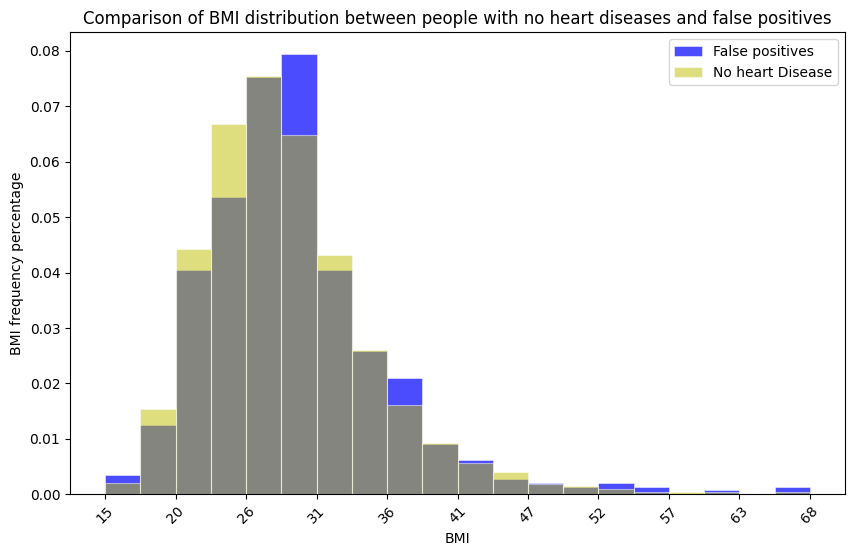

In [320]:
plt.figure(figsize=(10, 6))

plt.hist(false_positives_df['BMI'], bins=20, color='b', edgecolor='w', linewidth=0.5, alpha=0.7, density=True)
n2, bins2, patches2 = plt.hist(negatives_df['BMI'], bins=20, color='y', edgecolor='white', linewidth=0.8, alpha=0.5, density=True)
plt.xticks(bins2[::2], labels=np.around(bins2[::2]).astype(int), rotation=45) 

plt.ylabel("BMI frequency percentage")
plt.xlabel("BMI")
plt.title("Comparison of BMI distribution between people with no heart diseases and false positives")
plt.legend(['False positives', 'No heart Disease'])

plt.show()


It can be noticed that the BMI in the dataset with false positives prediction is higher on average than the BMI in the dataset of people without heart diseases.

### Age category

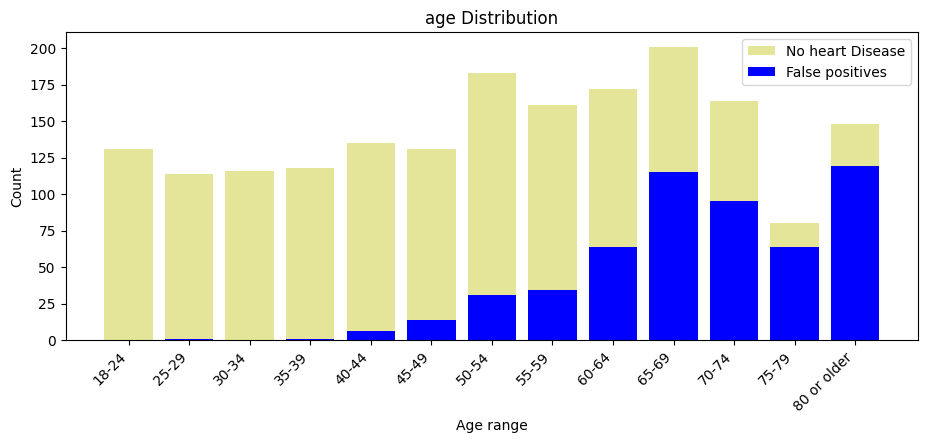

In [321]:
ages_false_pos = false_positives_df['AgeCategory'].value_counts().sort_index()
ages_neg = negatives_df['AgeCategory'].value_counts().sort_index()
# Creating the barplot
plt.figure(figsize=(11, 4))
plt.bar(list(ages_neg.index), ages_neg.values, color='y', alpha=0.4)
plt.bar(list(ages_false_pos.index), ages_false_pos.values, color='b', alpha=1)
plt.xlabel('Age range')
plt.ylabel('Count')
plt.title('age Distribution')
plt.xticks(rotation=45, ha='right')  
plt.legend(['No heart Disease', 'False positives'])
plt.show()

### Smoking

In [322]:
def plot_pie_chart_commparison(df_neg, df_false_pos, target, colors):
    plt.figure(figsize=(13, 8))
    plt.subplot(1, 2, 1)
    negative_values = df_neg[target].value_counts().sort_index()
    plt.pie(negative_values, labels=negative_values.index, autopct='%1.1f%%', startangle=90, colors = colors)
    plt.legend([f'{target}: '+ i for i in negative_values.index])
    plt.title(f'No heart diseases dataset')
    plt.subplot(1, 2, 2)
    false_positives_values = df_false_pos[target].value_counts().sort_index()
    plt.pie(false_positives_values, labels=false_positives_values.index, autopct='%1.1f%%', startangle=90, colors = colors)
    plt.title(f'False positives dataset')
    plt.show()

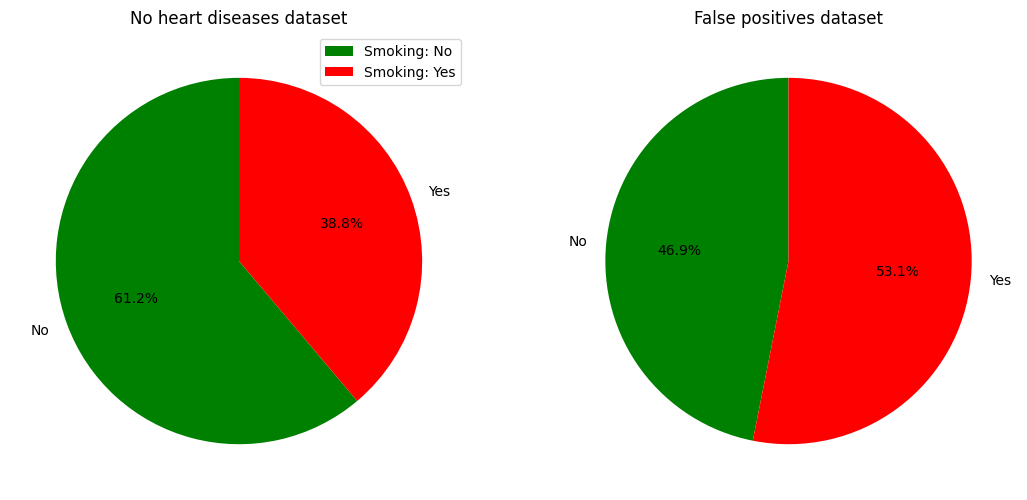

In [323]:
plot_pie_chart_commparison(negatives_df, false_positives_df, 'Smoking', colors=['g','r'])

### Stroke

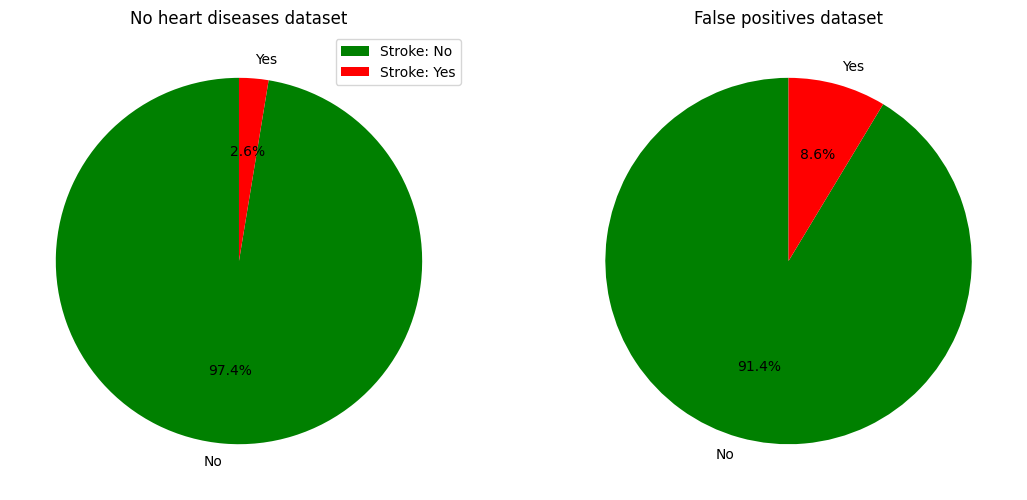

In [324]:
plot_pie_chart_commparison(negatives_df, false_positives_df, 'Stroke', colors=['g','r'])

### DiffWalking

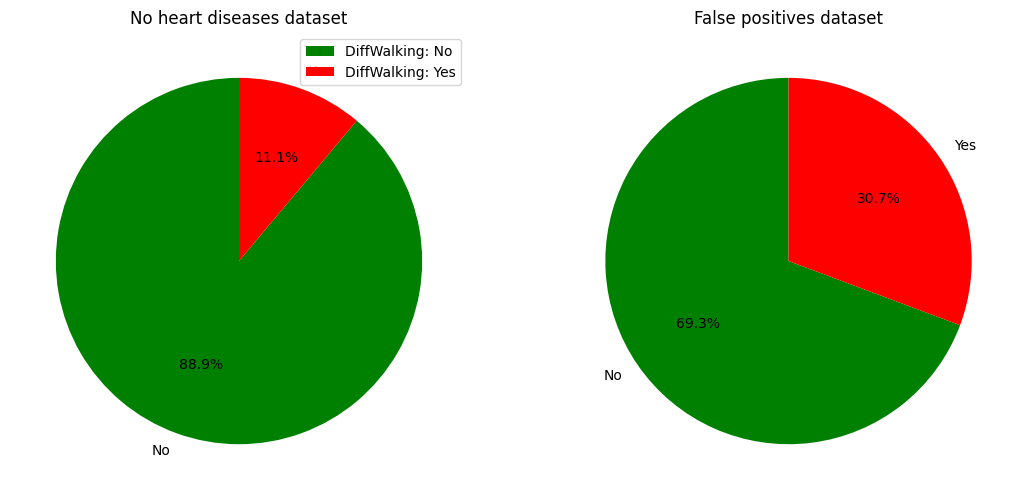

In [325]:
plot_pie_chart_commparison(negatives_df, false_positives_df, 'DiffWalking', colors=['g','r'])

### Diabetes

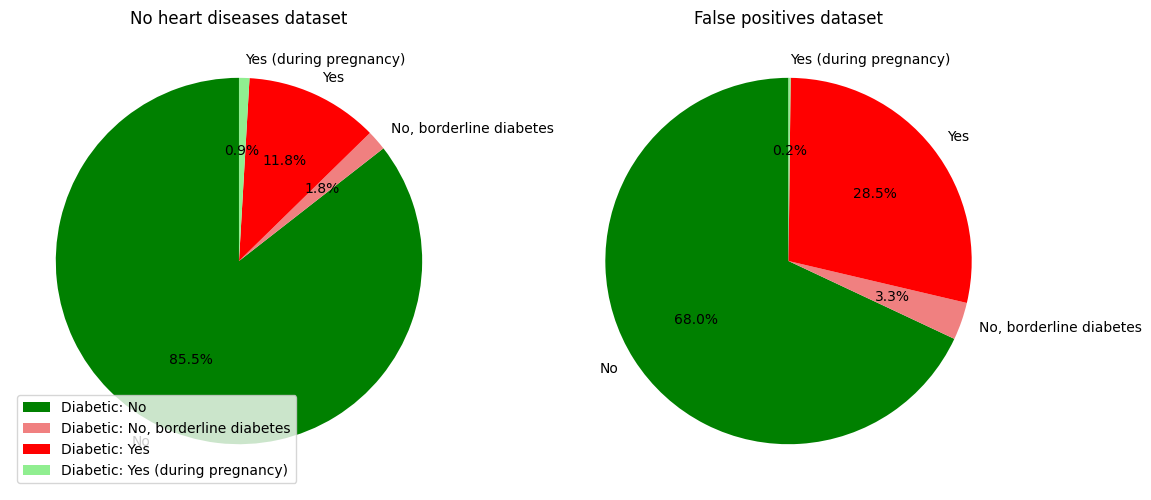

In [326]:
plot_pie_chart_commparison(negatives_df, false_positives_df, 'Diabetic', colors=['g','lightcoral','r', 'lightgreen'])

### PhysicalActivity

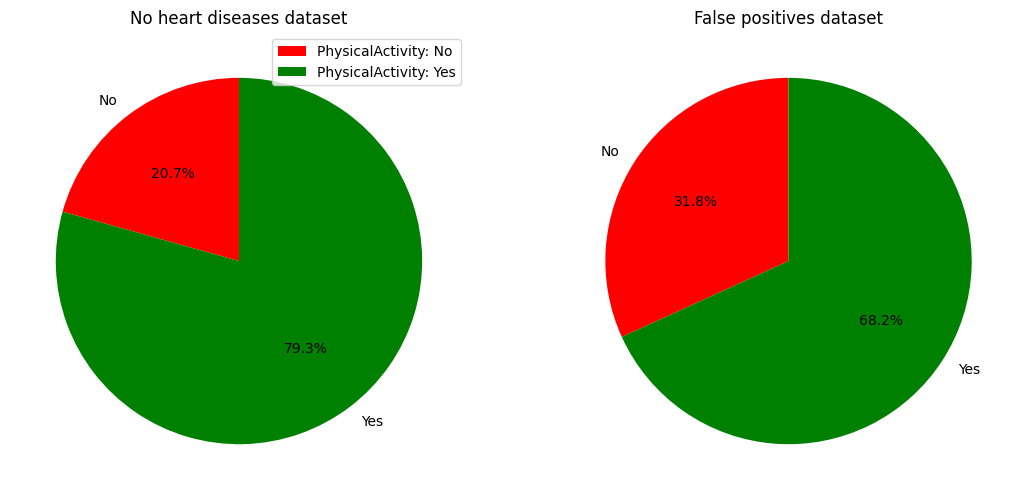

In [327]:
plot_pie_chart_commparison(negatives_df, false_positives_df, 'PhysicalActivity', colors=['r','g'])

### GenHealth

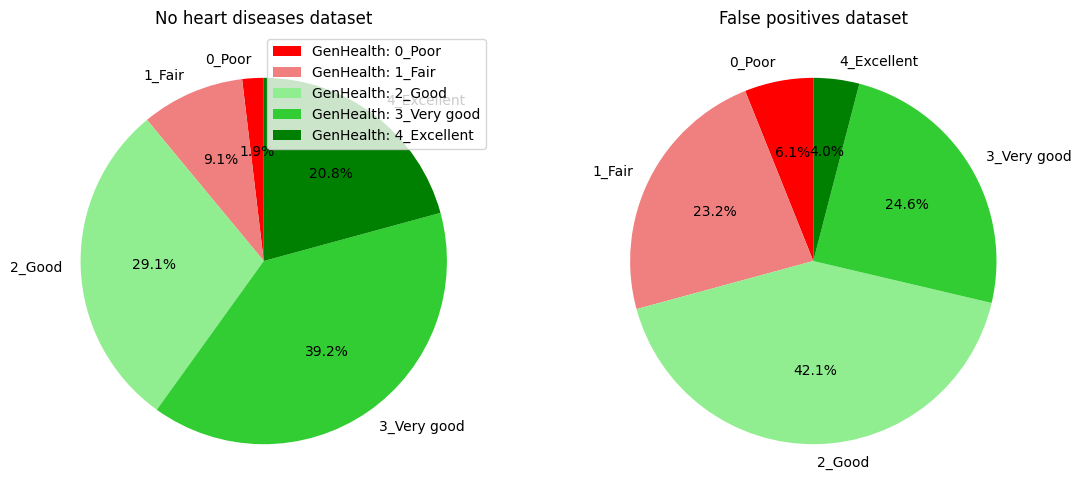

In [328]:
plot_pie_chart_commparison(negatives_df, false_positives_df, 'GenHealth', colors=['r','lightcoral','lightgreen','limegreen','g'])

### Asthma

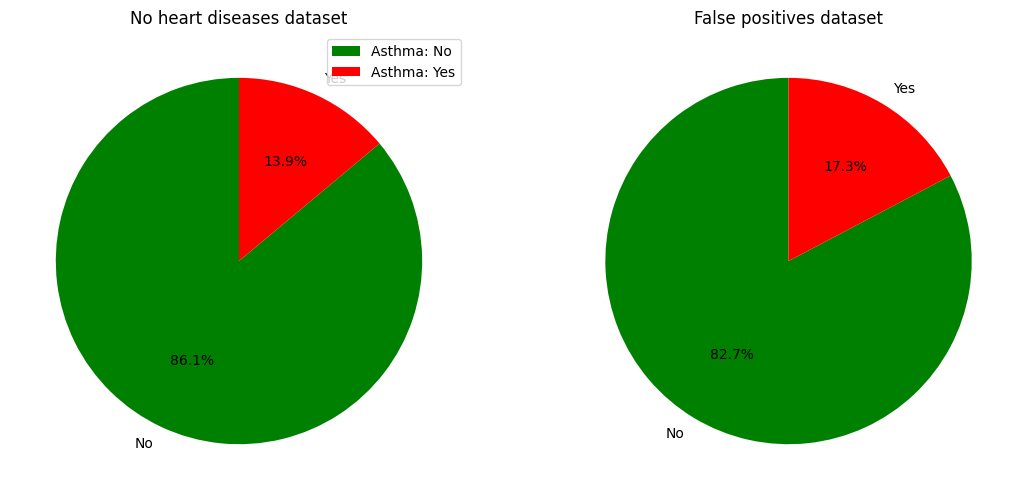

In [329]:
plot_pie_chart_commparison(negatives_df, false_positives_df, 'Asthma', colors=['g','r'])

### KidneyDisease

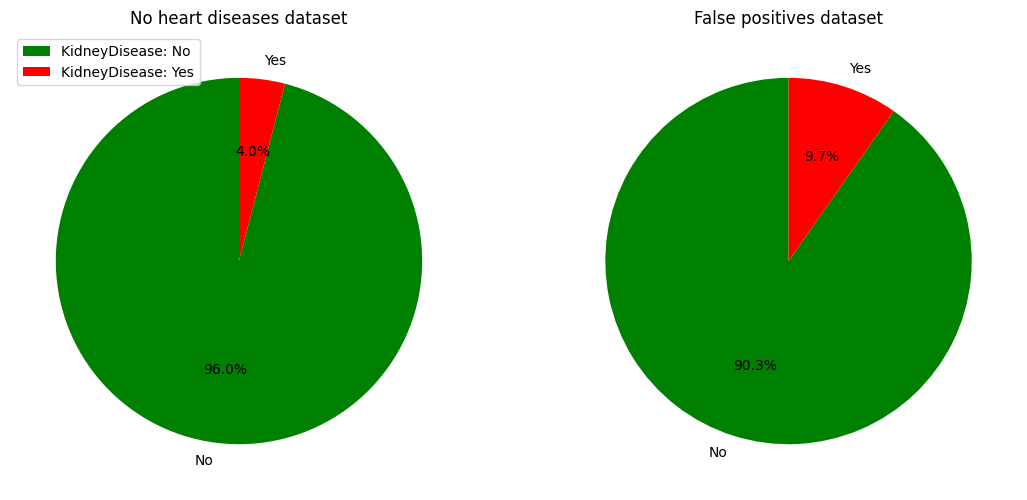

In [330]:
plot_pie_chart_commparison(negatives_df, false_positives_df, 'KidneyDisease', colors=['g','r'])

### SkinCancer

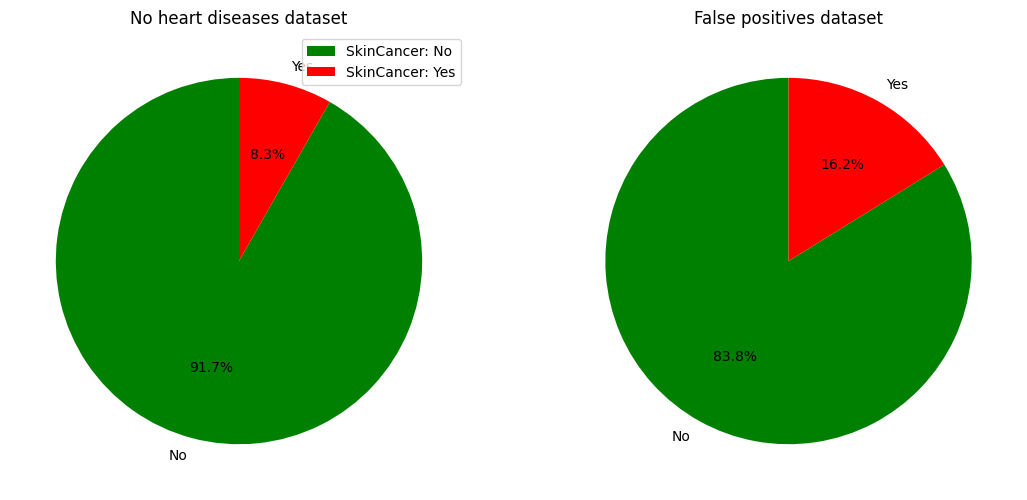

In [331]:
plot_pie_chart_commparison(negatives_df, false_positives_df, 'SkinCancer', colors=['g','r'])

## False negatives statistics

In [332]:
false_negatives_df = results_df[(results_df['Correct'] == False) & (results_df['correct_label'] == 'Heart Disease')].sort_values(['pred_prob'], ascending=False)
positives_df = results_df[results_df['correct_label'] == 'Heart Disease']
false_negatives_df.head()

,correct_label,Prediction,Correct,pred_prob,BMI,SleepTime,Smoking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
3817,Heart Disease,No Disease,False,0.498690,36.39,6.0,No,No,No,Female,35-39,Other,Yes,No,1_Fair,Yes,No,No
2581,Heart Disease,No Disease,False,0.497808,34.18,8.0,No,No,Yes,Female,65-69,White,No,No,2_Good,No,No,No
258,Heart Disease,No Disease,False,0.497729,37.47,10.0,Yes,No,No,Male,70-74,American Indian/Alaskan Native,No,No,4_Excellent,No,No,No
3092,Heart Disease,No Disease,False,0.496451,27.62,7.0,Yes,No,No,Male,65-69,Other,No,Yes,3_Very good,No,No,No
998,Heart Disease,No Disease,False,0.494510,34.33,7.0,Yes,No,Yes,Female,55-59,White,No,Yes,2_Good,No,No,No


### BMI

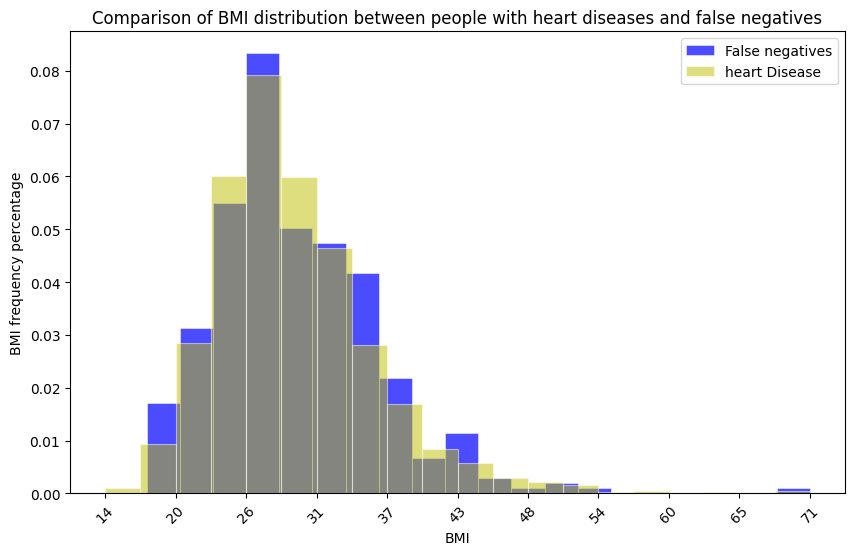

In [333]:
plt.figure(figsize=(10, 6))

plt.hist(false_negatives_df['BMI'], bins=20, color='b', edgecolor='w', linewidth=0.5, alpha=0.7, density=True)
n2, bins2, patches2 = plt.hist(positives_df['BMI'], bins=20, color='y', edgecolor='white', linewidth=0.8, alpha=0.5, density=True)
plt.xticks(bins2[::2], labels=np.around(bins2[::2]).astype(int), rotation=45) 

plt.ylabel("BMI frequency percentage")
plt.xlabel("BMI")
plt.title("Comparison of BMI distribution between people with heart diseases and false negatives")
plt.legend(['False negatives', 'heart Disease'])

plt.show()

### Age category

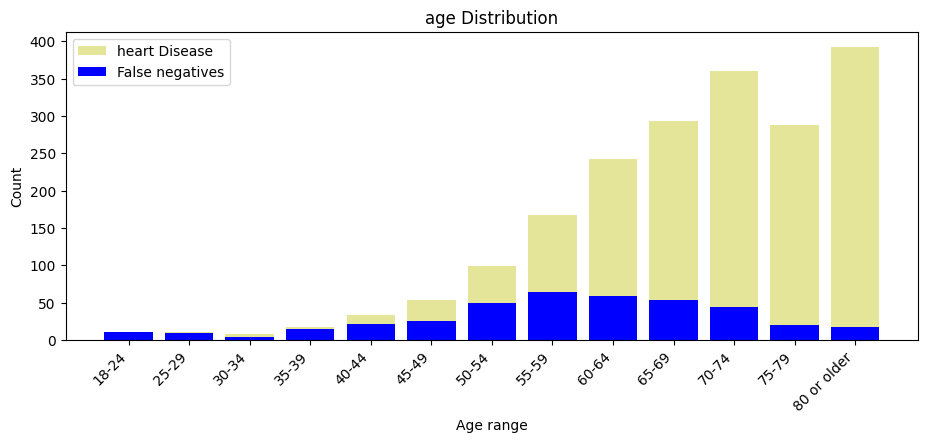

In [334]:
ages_false_neg = false_negatives_df['AgeCategory'].value_counts().sort_index()
ages_pos = positives_df['AgeCategory'].value_counts().sort_index()
# Creating the barplot
plt.figure(figsize=(11, 4))
plt.bar(list(ages_pos.index), ages_pos.values, color='y', alpha=0.4)
plt.bar(list(ages_false_neg.index), ages_false_neg.values, color='b', alpha=1)
plt.xlabel('Age range')
plt.ylabel('Count')
plt.title('age Distribution')
plt.xticks(rotation=45, ha='right')  
plt.legend(['heart Disease', 'False negatives'])
plt.show()

### Smoking

In [335]:
def plot_pie_chart_commparison(df_pos, df_false_neg, target, colors):
    plt.figure(figsize=(13, 8))
    plt.subplot(1, 2, 1)
    negative_values = df_pos[target].value_counts().sort_index()
    plt.pie(negative_values, labels=negative_values.index, autopct='%1.1f%%', startangle=90, colors = colors)
    plt.legend([f'{target}: '+ i for i in negative_values.index])
    plt.title(f'heart diseases dataset')
    plt.subplot(1, 2, 2)
    false_positives_values = df_false_neg[target].value_counts().sort_index()
    plt.pie(false_positives_values, labels=false_positives_values.index, autopct='%1.1f%%', startangle=90, colors = colors)
    plt.title(f'False negatives dataset')
    plt.show()

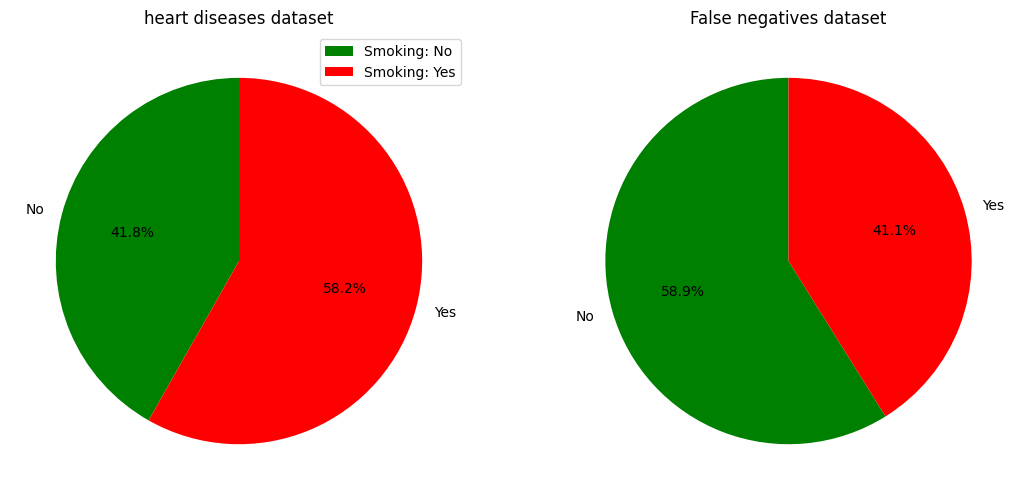

In [336]:
plot_pie_chart_commparison(positives_df, false_negatives_df, 'Smoking', colors=['g','r'])

### Stroke

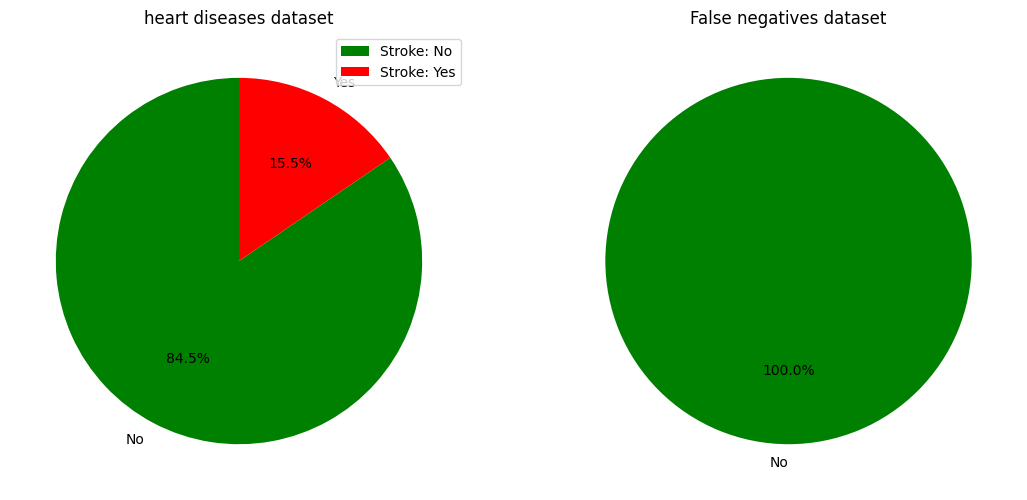

In [337]:
plot_pie_chart_commparison(positives_df, false_negatives_df, 'Stroke', colors=['g','r'])

### DiffWalking

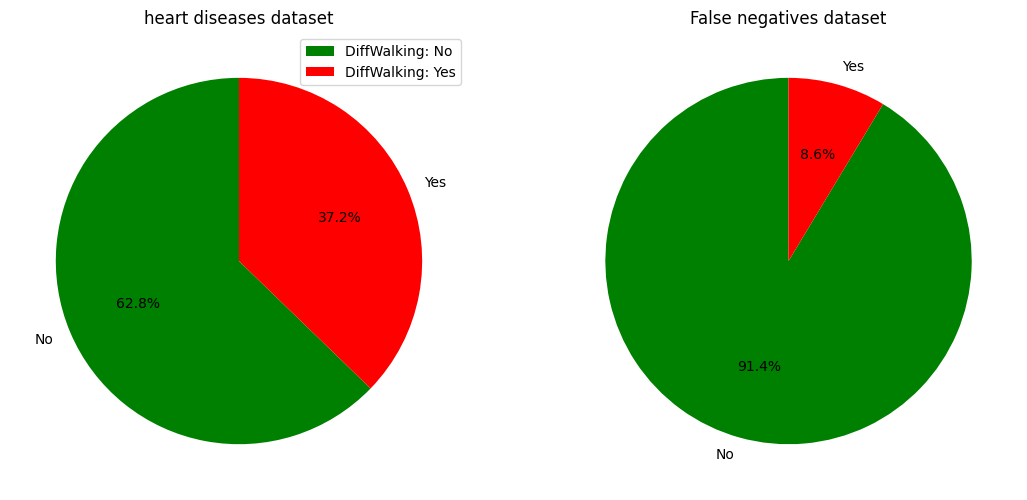

In [338]:
plot_pie_chart_commparison(positives_df, false_negatives_df, 'DiffWalking', colors=['g','r'])

### Diabetes

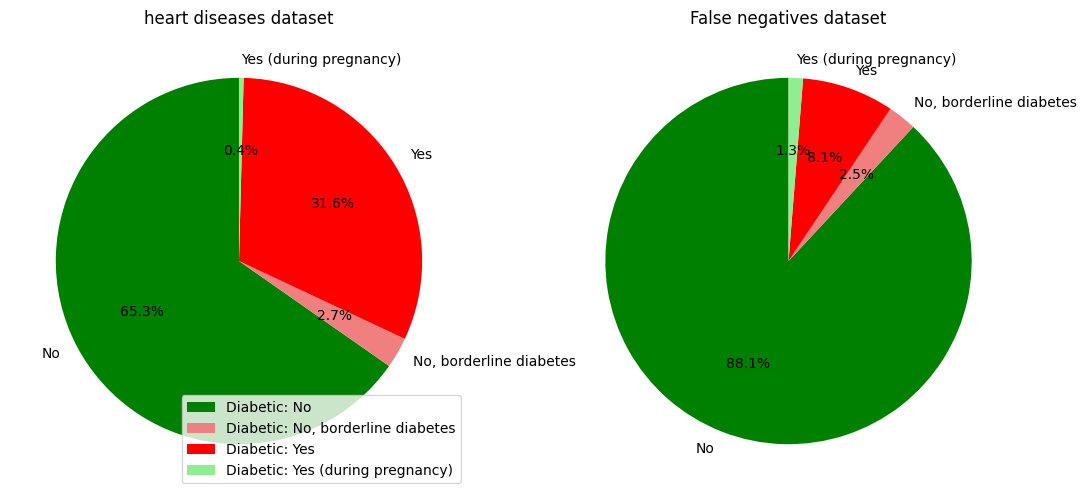

In [339]:
plot_pie_chart_commparison(positives_df, false_negatives_df, 'Diabetic', colors=['g','lightcoral','r', 'lightgreen'])

### PhysicalActivity

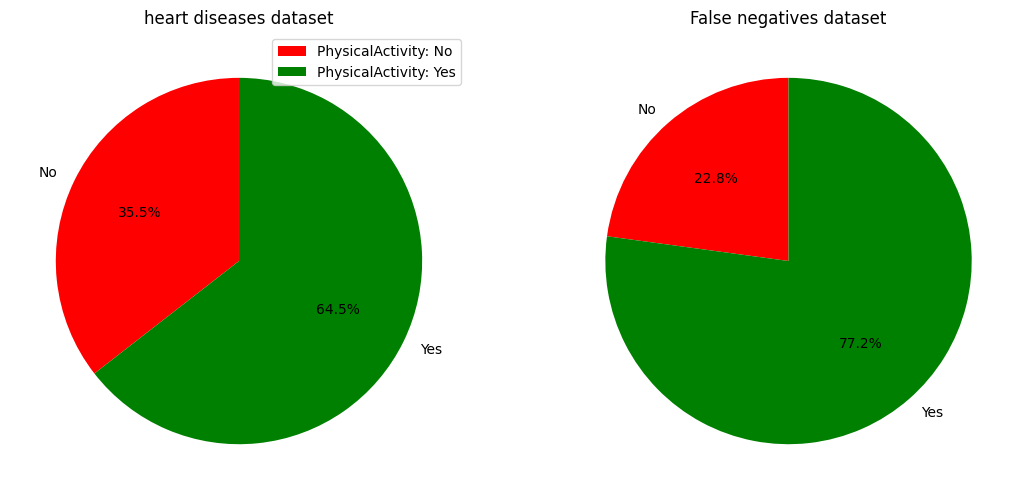

In [340]:
plot_pie_chart_commparison(positives_df, false_negatives_df, 'PhysicalActivity', colors=['r','g'])

### GenHealth

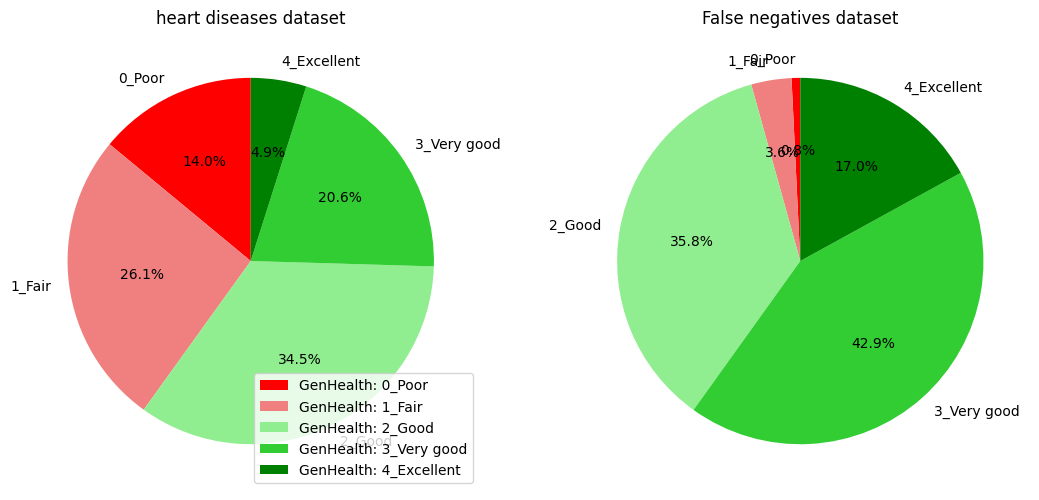

In [341]:
plot_pie_chart_commparison(positives_df, false_negatives_df, 'GenHealth', colors=['r','lightcoral','lightgreen','limegreen','g'])

### Asthma

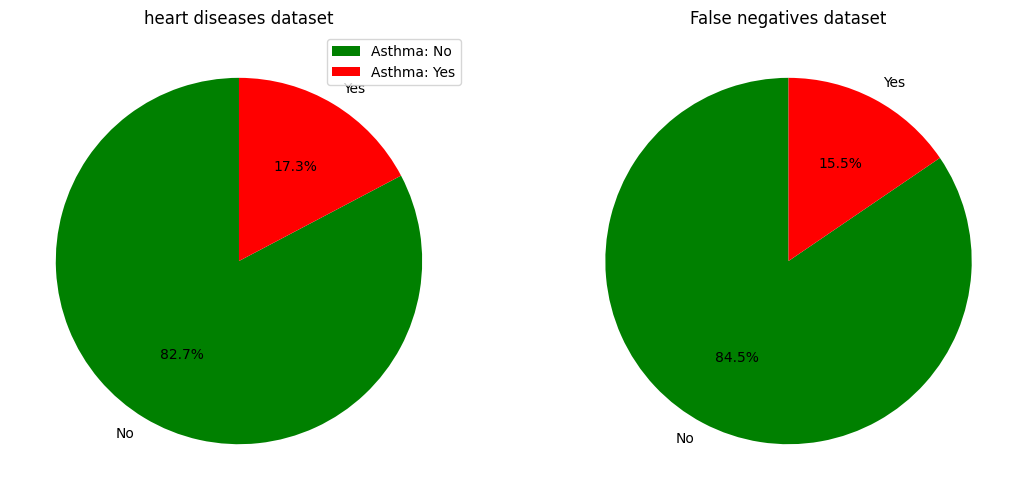

In [342]:
plot_pie_chart_commparison(positives_df, false_negatives_df, 'Asthma', colors=['g','r'])

### KidneyDisease

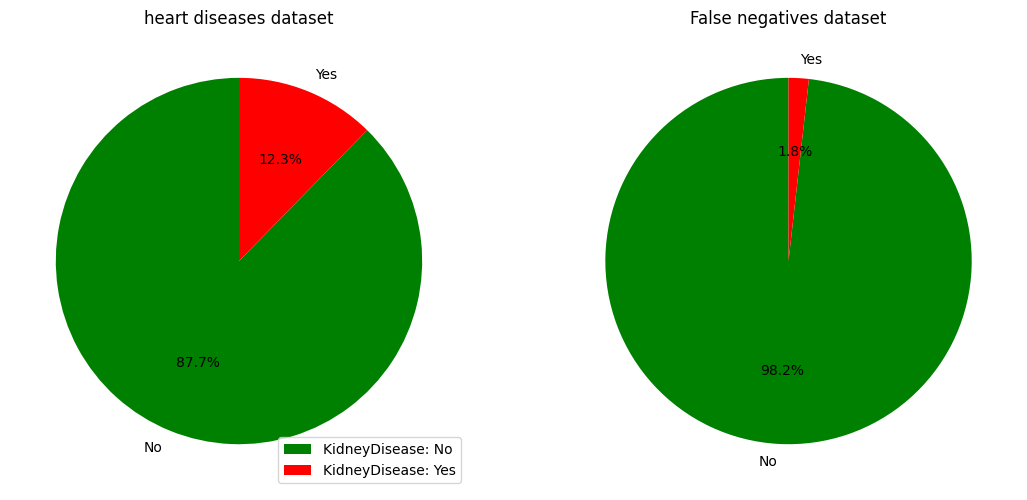

In [343]:
plot_pie_chart_commparison(positives_df, false_negatives_df, 'KidneyDisease', colors=['g','r'])

### SkinCancer

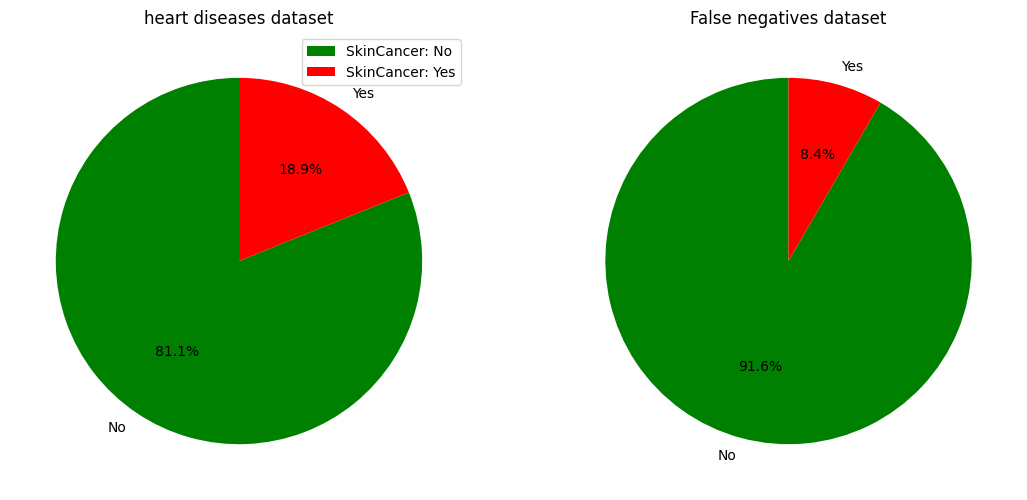

In [344]:
plot_pie_chart_commparison(positives_df, false_negatives_df, 'SkinCancer', colors=['g','r'])

# Final considerations

The best model performs with a 0.76 accuracy on the test set. The model is better at predicting people with heart diseases (0.8 recall) than people with no heart diseases (0.71 precision).

Different models exhibit comparable accuracy levels. Parameters optimization, as observed in LSTM, GRU (that are not reported in the notebook), Dense, and CNN models, resulted in similar accuracies.
This is probably due to the unpredicatbility of heart conditions and the fact that a percentage of the population does not develop heart conditions, even with an unhealthy lifestyle and poor overall health conditions.
 
In the previous section, we observed that individuals without a pre-existing heart condition, but predicted to have heart diseases, displayed health features commonly associated with individuals who have heart conditions. Viceversa, false negatives exhibited a lower prevalence of these distinctive features.